# Machine Learning @ UWr 2020

**Lecture 04**

In the previous lecture we have seen two models derived from a probabilistic perspective:

1. Linear regression can be derived to be the MLE or MAP estimator of a linear relationship under the assumption of Gaussian noise.
2. Naive Bayes classifier transforms the conditional probability of a class given the data into the probability of generating the observation, simplifies this distribution and estimates its parameters using a MLE or Bayesian procedure.

In this lecture we will explore this topic further, by deriving Logistic Regression - the classifier analoguous to Linear Regression.

We will also revisit Linear Regression, taking a closer look at its loss function and understanding what tradeoffs we can make.

## Logistic Regression for Irises

Lets get back to our Iris classification problem: preidct the flower species, based on `petal length` and `petal width` features (we limit ourselves to 2 dimesions to be able to plot what is happening).

Let's first load the data!

In [1]:
# Env setup!
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport
![ -e cifar.npz ] || gdown 'https://drive.google.com/uc?id=1oBzZdtg2zNTPGhbRy6DQ_wrf5L5OAhNR' -O cifar.npz
![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU' -O mnist.npz

In [2]:
import os
import sys

import numpy as np
import pandas as pd

import scipy.stats as sstats

from sklearn import datasets
import sklearn.linear_model

from matplotlib import animation, pyplot, rc
import matplotlib.pyplot as plt

import httpimport
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
     from common.plotting import plot_mat

Features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Targets:  ['setosa' 'versicolor' 'virginica']


Text(0, 0.5, 'petal_width')

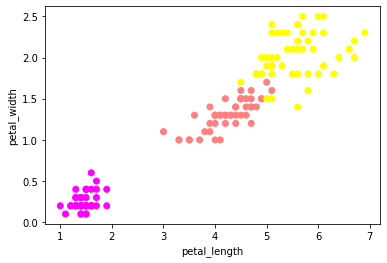

In [3]:
iris = datasets.load_iris()
print("Features: ", iris.feature_names)
print("Targets: ", iris.target_names)
petal_length = iris.data[:, iris.feature_names.index("petal length (cm)")].reshape(-1, 1)
petal_width = iris.data[:, iris.feature_names.index("petal width (cm)")].reshape(-1, 1)


plt.scatter(petal_length, petal_width, c=iris.target, cmap="spring")
plt.xlabel("petal_length")
plt.ylabel("petal_width")

We will first simplify our task and consider binary classification: tell Versicilors from Virginicas.

Only then, we will see how to generalize our approach to more classes.

### Logistic Regressoin intuitions

Looking at the Iris scaterplot, we intuitively see that we could draw a line which approximately separates the Versicolors from Virginicas. While it will not correctly classify all flowers near the boundary region, it will do a decent job for the more distant ones.

One such guesstimated line may be $6.5 - \text{petal length} - \text{petal width}=0$.

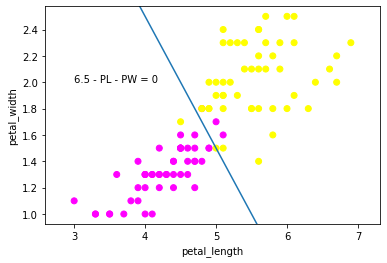

In [4]:
# Extract the petal_length and petal_width of versicolors and virginicas
IrisX = np.hstack([np.ones_like(petal_length), petal_length, petal_width])
IrisX = IrisX[iris.target != 0, :]

# Set versicolor=0 and virginia=1
IrisY = (iris.target[iris.target != 0] - 1).reshape(-1, 1).astype(np.float64)

plt.scatter(IrisX[:, 1], IrisX[:, 2], c=IrisY, cmap="spring")
plt.xlabel("petal_length")
plt.ylabel("petal_width")
ylim = plt.ylim()

# Guesstimate a separation boundary
plt.plot(plt.xlim(), 6.5 - np.array(plt.xlim()))
plt.ylim(*ylim)
_ = plt.text(3,2,"6.5 - PL - PW = 0")

### Why not regress features directly onto probabilities

How can we obtain this separating line?

One posible solution would be to simply treat the binary class identifier as a numerical value, and fit a linear regression model, hpoing that it will output a number close to 0 for one class and close to 1 for the other class. 

However, this simplified approach has certain disadvantages. For instance, how do we interpret an output of 2? Is the model extremely confident about its output? 

Moreover, the least squares criterion doesn't make much sense: for instance, when $y=1$, it penalizes an output of 2 in the same way as an noutput of 0 (the distance from the target 1 is the same in both cases)!

### Regression with a squasing function

Getting back to classification problem, we want to model the conditional probability 
$$
p(\text{class}|\text{petal length}, \text{petal width}) = p(y|x)
$$

This conditioanl probability should depend on the distance of a point to the separating boundary. Points near the separating line are ambiguous - probablity there should be close to 0.5. On the other hand, the model should be failry certain on points far away from the separating boundary.

We thus need to squash the distance from the boundary to the $0-1$ range of valid probabilities. We will accomplish this by mapping the distance through a "sigmoid" (meaning S-shaped function). A very popular function is the logistic sigmoid:
$$
\sigma(z) = \frac{1}{1+e^{-z}}
$$

Let's see how it looks like.

Text(0.5, 1.0, 'The logistic sigmoid function')

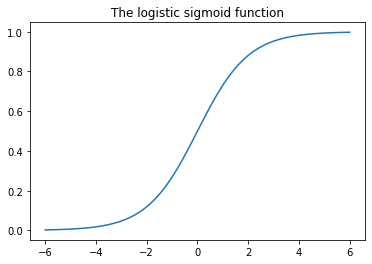

In [5]:
z = np.linspace(-6,6,100)
plt.plot(z, 1/(1+np.exp(-z)))
plt.title('The logistic sigmoid function')

### Properties of the logistic sigmoid

The logistic sigmoif has a few nice properties:

1. $\sigma(0) = 0.5$. This means that points exaclt on the separating line are ambigous, just like we desired.
2. $\lim_{z\rightarrow \infty} \sigma(z) = 1$ and $\lim_{z\rightarrow -\infty} \sigma(z) = 0$: the further we are from the separating boundary, the more confident the model.
3. $\sigma(-z) = 1 - \sigma(z)$. The function is symmetrical, it doesn't matter which class we treat as the "positive" one.

### Definition of the Logistic Regression model

Armed with the $\sigma$ squashing function, let's define:

$$
p(y=1|x;
Theta) = \sigma(x\Theta),
$$
where $x$ is a row vector of features $y$ is a random variable denoting the target class and $\Theta$ is a column vector of model parameters.

### Logistic regression loss function

To fit parameters $\Theta$, 
we will again use the mMximum Likelihood principle. Please observe that:

$$
\begin{align}
p(y=y^{(i)}|x^{(i)};\Theta) &= \cases{p(y=1|x;\Theta) &if $y^{(i)}=1$ \\ 1-p(y=1|x^{(i)};\Theta) &if $y^{(i)}=0$} \\
&= p(y=1|x^{(i)};\Theta)^{y^{(i)}}(1-p(y=1|x^{(i)};\Theta))^{(1-y^{(i)})} \\
&= \sigma(x^{(i)}\Theta)^{y^{(i)}}(1-\sigma(x^{(i)}\Theta))^{(1-y^{(i)})}
\end{align}
$$

Therefore the negative log likelihood ($nll$) is:
$$
\begin{split}
nll(\Theta) &= -\sum_{i=1}^{N} y^{(i)} \log \sigma(x^{(i)}\Theta) + (1-y^{(i)})\log(1-\sigma(x^{(i)}\Theta)) = \\
&= -\sum_{i=1}^{N}y^{(i)}\log p(y=1|x^{(i)}; \Theta) + (1-y^{(i)})\log  p(y=0|x^{(i)}; \Theta)
\end{split}
$$

This loss function is often referred to as the *cross-entropy* loss.


## Logistic regression training

We now need to find the $\Theta$ which minimizes the likelihood function. Again, we will use calculus and compute the gradient of the nll. We will do it in steps. First please observe how simple is the gradient of the logistic sigmoid function:

$$ \frac{\partial}{\partial z}\sigma(z) = \sigma(z)(1-\sigma(z))$$

Now let $z^{(i)} = x^{(i)}\Theta$. First lets compute the gradient of the loss on a single sample $nll^{(i)}$:

$$
\frac{\partial nll^{(i)}(\Theta)}{\partial \Theta} = \frac{\partial nll^{(i)}}{\partial z^{(i)}}\frac{\partial z^{(i)}}{\partial\Theta}
$$

The derivative of the first term on the right hand turns out to be very simple:

$$
\begin{align}
\frac{\partial nll^{(i)}}{\partial z^{(i)}} &= \frac{\partial -\left(y^{(i)} \log \sigma(z^{(i)}) + (1-y^{(i)})\log(1-\sigma(z^{(i)}))\right)}{\partial z^{(i)}} \\
&= -y^{(i)}\frac{\sigma(z^{(i)})(1-\sigma(z^{(i)}))}{\sigma(z^{(i)})} + 
(1-y^{(i)})\frac{\sigma(z^{(i)})(1-\sigma(z^{(i)}))}{1-\sigma(z^{(i)})} \\
&= -y^{(i)}(1-\sigma(z^{(i)})) + (1-y^{(i)})\sigma(z^{(i)})\\
&=\sigma(z^{(i)})-y^{(i)}
\end{align}
$$

The second term $\frac{\partial z^{(i)}}{\partial\Theta}$ is also easy:

$$
\frac{\partial z^{(i)}}{\partial\Theta} = \frac{\partial x^{(i)}\Theta}{\partial\Theta} = (x^{(i)})^T
$$

Taken together the loss derivative is:

$$
\frac{\partial nll(\Theta)}{\partial \Theta} = \sum_{i=1}^{N}\frac{\partial nll^{(i)}}{\partial z^{(i)}} = \sum_{i=1}^{N}(x^{(i)})^T\left(\sigma(z^{(i)})-y^{(i)}\right)
$$

The expression can be further simplified by using the data matrix $X$ (of shape $N\times D$ whose $i$-th row is the $i$-th sample), the target matrix $Y$, letting $Z=X\Theta$, and assuming that the function $\sigma()$ is applied separately to all elements of its input.

$$
\frac{\partial nll(\Theta)}{\partial \Theta} = X^T\left(\sigma(Z)-Y\right)
$$

#### Comparison of gradients of Linear and Logistic Regression

Recall from Lecture 2, that the linear regression gradient we have derived was proportional to
$$
X^T(X\Theta - Y) = X^T E
$$
where just like for logistic regression $X$ is the $X\times D$ data matrix, $Y$ is the $X\times 1$ coliumn vector of targets, and $E$ is the column vector of errors.

Notice, that for Logistic regression the gradient takes exxentially the same form:

$$
X^T\left(\sigma(X\Theta) - Y\right) = X^T E'
$$

where $E'$ is the "error" of logistic regression - the difference betweenn the desired target, encoed as $0$ or $1$ and the probability assigned by the model.

This is not a coincidence. Linear and Logistic regresison belong to the family of [generalized linear models](https://en.wikipedia.org/wiki/Generalized_linear_model), which contains many more regression-like models.

Unfortunately, the gradient of the loss is no longer linear with $\Theta$. No closed-form solution exists. Therefore we will search for the minimum of the loss function by taking small steps along the gradient of the loss. We will call this the **gradient descent**.

### The Gradient Descent algorithm

Due to the nonlinear $\sigma$ function appearing in the gradient of neg-log likelihood for logistic regression, we can't derive a closed form formula for the zero-crossing of the gradient.

Instead we will follow an iterative minimization procedure. Recall that the negated gradient of a function points in the direction of the maximal function decrease (in fact, one can define the gradient to be direction of maximum function increase for an inifitesimally small step).

Our approach to solving the linear regression problem will follow this intuition: we will evaluate the neg-log likelihood, take its gradient, then make a small step against the gradient, hopefully getting a smaller neg-log likelihood value. After many such steps we hope to get to a local minimum - a point where the gradient is zero, and we can't go any lower.

It turns out, that again our optimization problem is convex, and the local minimum reached with gradient descent will be the global one.

The gradient descent algorithm is very simple:

* $\Theta \gets $ a sane initial value
* `While` not converged:
    * 
$\Theta \gets \Theta - \alpha \frac{\partial L(\Theta)}{\partial\Theta}$

When GD converges, gradient is close to zero and neg-log likelihood stops to change. 


#### We will now see a demonstration of GD solving the logistic regression on Irises

Please note, that unlike previous lectures, the details of the implementation are missing: you will implement logistic regression during the programming assignment!

In [6]:
#@title Logistic regression implementation
# This code is part of homework assignment and is removed on purpose


In [7]:
#note: the step-size needs to be tuned!
ThetaOpt, history = logreg(IrisX, IrisY, alpha=1e-2, stop_tolerance=1e-8, max_steps=100000)
print(f"Gradient descent made {len(history)} steps")
print("Theta is: ", ThetaOpt)

Gradient descent made 81528 steps
Theta is:  [-45.08388493   5.726315    10.4161067 ]


In [8]:
# Make an animation of training

fig = plt.figure()
ax = plt.axes()
ax.scatter(IrisX[:, 1], IrisX[:, 2], c=IrisY, cmap="spring")
plt.xlabel("petal_length")
plt.ylabel("petal_width")

xlim = np.array(plt.xlim())
ylim = plt.ylim()

line, = plt.plot([],[])

plt.close()

def init():
    line.set_data([], [])
    return line,

def animate(i):
    epoch = 1 + int(1.0 * (len(history)-1) / num_frames * i)
    Theta = history[epoch]
    ax.set_title('Epoch %d, Theta: %s' % (epoch, Theta,))
    yy = (Theta[0] + xlim * Theta[1]) / - Theta[2]
    line.set_data(xlim, yy)
    return line,

num_frames=100
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=30, blit=True)
rc('animation', html='jshtml')
anim

Output hidden; open in https://colab.research.google.com to view.

The animation shows how logistic regression iteratively moves the separating line towards its final location.

## Softmax Regression - dealing with multiple classes

We will now generalize Linear Regression to handle many classes.

The model will produce a probability distribution over the $k$ classes: it will have $k$ outputs, each corresponding to the probability of one class. The outputs will be constrained ot sume to one.

Intuitively, the model will first compute a score for each class. The scores are independent, each score is computed using a linear projection of the features:

$$
z_k = x\Theta_k,
$$

where $z_k$ is the score for class $k$ and $\Theta_k$ is the **vector** of scoring parameters for the $k$-th class.

We can egain use matrix algebra and drop the indices:
$$
z = x\Theta
$$
with $z\in\mathbb{R}^{1\times k}$ is the vector of scores, $x\in 1\times D$ is the vector with a sample's fetures and $\Theta\in{D\times k}$ is the **matrix** of all paramaters.

We will normalize the sores using the SoftMax function:

$$
\text{SoftMax}(z)_j = \frac{e^{z_j}}{\sum_k e^{z_k}}
$$

Please note, that SoftMax works on all the scores at once, it is not an elementwise function. In particular, the output for one class depends on all other ones, beacuse they are jointly normalized to sum to 1.

Thus SoftMax regression learns the function

$$
h(x, \Theta) = \text{SoftMax}(x\Theta).
$$

And we interpret the model's outputs as probabilities:

$$
p(y=k|x;\Theta) = h(x, \Theta)_k = \text{SoftMax}(x\Theta)_k.
$$

Application of the MLE principle yields the cross-entropy loss, which is analogous to the one for linear regression:

$$
J(\Theta) = -\sum_{i=1}^N\sum_k[y^{(i)}=k]\log \left(h(x^{(i)}, \Theta)_k\right)
$$

where $[y^{(i)}=k]$ is an indicator function which takes value 1 if $y^{(i)}=k$ and 0 otherwise.

SoftMax regression is a generalization of logistic regression, which we will show in a homework assignment.

Let's now apply SoftMax regression to the full Iris data.

In [9]:
IrisX = np.hstack([np.ones_like(petal_length), petal_length, petal_width])
IrisY = iris.target.reshape(-1, 1)

ThetaIris = softmax_regression(
    IrisX, IrisY, 3, maxiter=25)

In [10]:
IrisPreds = IrisX @ ThetaIris
iris_acc = np.mean(IrisPreds.argmax(-1) == IrisY[:,0]) * 100.0
print(f"SoftMax regression training accuracy on Iris: {iris_acc:.2f}%")

SoftMax regression training accuracy on Iris: 96.00%


### More examples of Softmax Regression

Picturing the weigths of Softmax Regression weigths on Iris is challenging, because the weigths only make sense only when taken jointly - for the model to predict a class, it must score high relatively to the other classes.

However, on image data the weigths can be pictured as images - it will show us which pixels affect the probabiity of each class.

We will use two datasets containing images - MNIST and CIFAR10. They both contain samples belonging to 10 classes. Therefore for each dataset we will find a set of parameters for each of the 10 classes. Then we will display the parameters as images. We can think about them as prototype vectors sensitive to elements of a given class.

In [11]:
with np.load('mnist.npz') as data:
    mnist_train_data = data[
        'train_data'].astype(np.float32).reshape(-1, 28*28) / 255.0
    mnist_train_labels = data['train_labels']
    mnist_test_data = data[
        'test_data'].astype(np.float32).reshape(-1, 28*28) / 255.0
    mnist_test_labels = data['test_labels']

In [12]:
# note: we want to keep the number of iterations low, afterwards we may 
# start to overfit. This will firther explained in later lectures.
ThetaMnist = softmax_regression(
    mnist_train_data, mnist_train_labels, 10, maxiter=25)

In [13]:
predicted_train_labels = (mnist_train_data @ ThetaMnist).argmax(1)
print (f"Train error rate: {(predicted_train_labels != mnist_train_labels).mean()*100:.2f}%")

predicted_test_labels = (mnist_test_data @ ThetaMnist).argmax(1)
print (f"Test error rate: {(predicted_test_labels != mnist_test_labels).mean()*100:.2f}%")

Train error rate: 8.44%
Test error rate: 8.29%


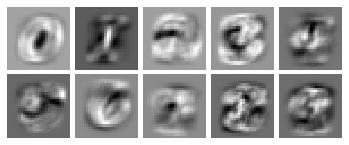

In [14]:
plot_mat(ThetaMnist[:,:].reshape(28,28,1,-1).transpose(3,2,0,1), cmap='gray')

In [15]:
with np.load('cifar.npz') as data:
    cifar_train_data = data[
        'train_data'].astype(np.float32).reshape(-1, 32*32*3) / 255.0
    cifar_train_labels = data['train_labels']
    cifar_test_data = data[
        'test_data'].astype(np.float32).reshape(-1, 32*32*3) / 255.0
    cifar_test_labels = data['test_labels']

In [16]:
# note: we want to keep the number of iterations low, afterwards we may 
# start to overfit. This will befurther explained in later lectures
ThetaCifar = softmax_regression(
    cifar_train_data, cifar_train_labels, 10, maxiter=50)

In [17]:
predicted_train_labels = (cifar_train_data @ ThetaCifar).argmax(1)
print(f"Train error rate: {(predicted_train_labels != cifar_train_labels).mean()*100:.2f}%")

predicted_test_labels = (cifar_test_data @ ThetaCifar).argmax(1)
print(f"Test error rate: {(predicted_test_labels != cifar_test_labels).mean()*100:.2f}%")

Train error rate: 59.83%
Test error rate: 60.77%


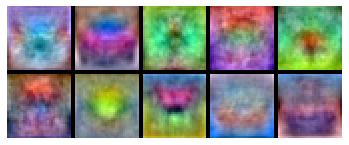

In [18]:
# We skip the first row of parameters because they represent the 
# constant term. The remaming ones are rehsaped as RGB images
#
# The 10 classes are:
# ------------------------------------------------
# | airplane | automobile | bird  | cat  | deer  |
# |----------|------------|-------|------|-------|
# |   dog    |     frog   | horse | ship | truck |
# ------------------------------------------------
#
# Again, the learned parameters ressebmle the average image in each class.
#
plot_mat(ThetaCifar[:,:].reshape(32,32,3,-1).transpose(3,2,0,1))

## Linear regression revisited

We now will explore what consequences on model behavior have the assumptions we can make about the error probability distribution.

Our analysis will focus on robustness of some loss functions, understood as their resilience to:
- mismatch between our assumptions and the actil data,
- errors in the data, most notably sensitivity to erroneous or outlying data points.

Before we tackle linear regression, let's consider two estimators for the "typical value" of a data sample, namely:
- mean,
- median.

**Observation 1**: tiny movements to any data point change the mean. Moreover, bu moving any point by a large amount, we arbitralily move the mean.

These properties of the mean result in a fragility of the arithmetic mean. Potentially a large error in a _single_ data point will drastically influence the estimator!

On the other hand, if there are no outliers, and the points are really normally distributed, the population mean very quickly converges to the distributions mean. Intuitiely, fast convergence is due to its dependence on all points - it extracts a little bit of information from each data point.

**Observation 2**: tiny movements to most data points don't change the median (Intuition: the median lies between two dat points closest to it. If we wiggle one of them a bit, the median will wiggle as well). A large movement to any point cannot arbitraly change the median. Again, the only two points that can influence the median are thw two closest to it. If we move eny of them far away, they will no longer be the closes points.

Thus, the median is stable or robust - a small group of outliers can't affect it.

On the other hand we only extract information from the "middle points". In fact, if we treat the median as the minimizer of the absolute valued distance, all points between the middle two yield equally low loss, and the precision of estimation is proportional to the spacing between points. 

In Homerwork 1 we have seen that:
- the mean is the MLE estimator for the location of a normally distributed random variable, i.e.

  $$
    p(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2},
  $$

- the median is the MLE extimator for the location of a laplace random variable, i.e.

  $$
    p(x) = \frac{1}{2b}e^{-\frac{|x-\mu|}{b}}.
  $$

Moreover:
- assumption of normally distributed errors yields a least squares cost, also called L2 norm,
- assumption of laplace distributed errors yields a sum-of-absolute values cost, also called L1 norm.

The two cost functions will behave in a radically different way in the presence of outliers: the L2 cost will put a large weight to outliers, while the L1 cost will mostly ignore them.

We can get intuitions about the behavior of Normal and Laplace random variables by looking at their probability mass functions on a logarithmic scale.

The normal distribution has a fairly large probability mass near its mean, then quickly rolls down. Intuitively, observing a very large value far away from the mean is improbable, seeing one hase a large influence on the MLE estimator (mean).

On the other hand the Laplace has "fatter tails" - the probability of seeing a large value doesnt decrease as fast. Intuitively, this means that seeing a very larg value, far away from its mean is not that improbable, and its influence on the MLE estimator (median) will not be that large.


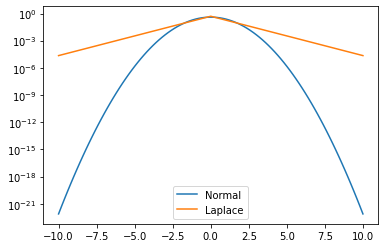

In [19]:
xx=np.linspace(-10, 10, 101)
plt.semilogy(xx, sstats.norm.pdf(xx), label='Normal')
plt.semilogy(xx, sstats.laplace.pdf(xx), label='Laplace')
plt.legend()

The difference is also visible when we look at the derivatives of the neg log-likelihoods (L1 and L2 norms) (we ignore that absolute value is not differentialbe at 0).

On the plot we can see, that no matter how large the error is, the L1 loss "pushes" with the same force, while the L2 loss pushes more for larger errrors.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


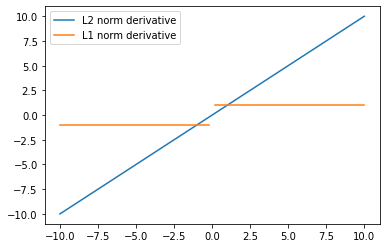

In [20]:
plt.plot(xx, xx, label='L2 norm derivative')
plt.plot(xx, np.sign(xx) / np.abs(np.sign(xx)), # this division will insert a NaN for xx=0
         label='L1 norm derivative')
plt.legend()

### Huber loss, or the best of both worlds

When there are no outliers, the mean's covergence to the location of the underlying probability distribution is faster than the convergence of median.

Intuitively, to keep the "best of both workds" we would want to reject the outliers, then use the inliners to compute the mean. 

The [Huber loss](https://en.wikipedia.org/wiki/Huber_loss) tries to do this automatically - it ressembles a square function for small deviations, and the sbsolute value for large ones:

$$
L_\delta (a) = \begin{cases}
 \frac{1}{2}{a^2}                   & \text{for } |a| \le \delta, \\
 \delta (|a| - \frac{1}{2}\delta), & \text{otherwise.}
\end{cases}
$$

It is a piecewise function, in the $\delta$ radius it is quadratic, out f it it grows linearly.

### The pseudo-Huber loss

The Huber loss is a piecewise function, making it non-smooth (the second derivative is not contigupous at the splicing points). A smooth approximation is:
$$
\delta^2\left(\sqrt{\left(\frac{x}{\delta}\right)^2 + 1} - 1\right)
$$

Below we plot L2 loss long with Huber and pseudo-Huber:

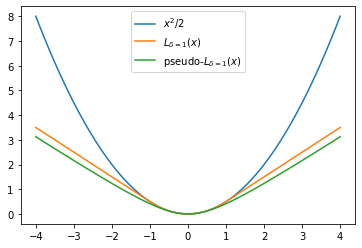

In [21]:
def L(a, delta):
    return np.where(np.abs(a) <= delta, 
                    0.5*a**2, 
                    delta*(np.abs(a) - 0.5 * delta))

x = np.linspace(-4, 4, 100)
plt.plot(x, 0.5 * x**2, label='$x^2/2$')
plt.plot(x, L(x, 1), label='$L_{\delta=1}(x)$')
plt.plot(x, np.sqrt(x**2 + 1) - 1, label=r'pseudo-$L_{\delta=1}(x)$')
plt.legend()

### Demonstration

We will now demonstrate the behavior of linear and Huber regression in the presence of outliers. Please note that programming assignment 2 compares linear regression to L1 regression, and introduces its generalization called "quantile regression".

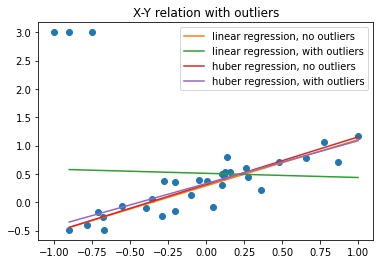

In [22]:
# We repeat here code from Lecture 02!

def gen_data(N=10, sigma_noise=.2, fun='poly2'):
    X = 2 * np.random.rand(N) - 1.0
    # sort the data 
    X = np.sort(X).reshape(-1, 1)
    eps = np.random.randn(N, 1) * sigma_noise
    if fun=='poly1':
        Y = 0.3 + .7*X + eps
    elif fun=='poly2':
        Y = 0.3 + .7*X -1.1*X**2 + eps
    elif fun =='log':
        Y = np.log(X+1)**.5 + eps
    elif fun == 'sin':
        Y = np.sin(3*np.pi*X) + eps
    else:
        raise ValueError(f"Unknown fun type: {fun}.")
    if sorted:
        xind = np.argsort(X[0, :])
        X= X[:, xind]
        Y= Y[:, xind]
    return X, Y


def expand(x, d):
    powers = np.arange(d + 1).reshape(1, -1)
    # Hint: if you don't understand this code, read about broadcasting!
    x_expanded = x.reshape(-1, 1) ** powers
    return x_expanded


class PolyRegression(sklearn.linear_model.LinearRegression):
    def __init__(self, degree):
        self.degree = degree
        # We don't fit the intercept, because we have explicitely added the 0-th power
        # of X to the expended representation.
        super().__init__(fit_intercept=False)
    
    def fit(self, x, y):
        return super().fit(expand(x, self.degree), y) 

    def predict(self, x):
        return super().predict(expand(x, self.degree)) 


class PolyHuberRegression(sklearn.linear_model.HuberRegressor):
    def __init__(self, degree):
        self.degree = degree
        # We don't fit the intercept, because we have explicitely added the 0-th power
        # of X to the expended representation.
        super().__init__(fit_intercept=False)
    
    def fit(self, x, y):
        return super().fit(expand(x, self.degree), y) 

    def predict(self, x):
        return super().predict(expand(x, self.degree)) 


XC,YC = gen_data(N=30, sigma_noise=0.2, fun='poly1')
# now append some outliers

XO = np.concatenate([XC, [[-1], [-0.9], [-0.75]]], axis=0)
YO = np.concatenate([YC, [[3], [3], [3]]], axis=0)
fig = plt.figure()
plt.plot(XO, YO, 'o') #note: plot assumes that each column is a data series
plt.title('X-Y relation with outliers')


degree = 1

plt.plot(XC, 
         PolyRegression(degree).fit(XC, YC).predict(XC), 
         '-', label=f'linear regression, no outliers')

plt.plot(XC, 
         PolyRegression(degree).fit(XO, YO).predict(XC), 
         '-', label=f'linear regression, with outliers')

plt.plot(XC, 
         PolyHuberRegression(degree).fit(XC, YC.ravel()).predict(XC), 
         '-', label=f'huber regression, no outliers')

plt.plot(XC, 
         PolyHuberRegression(degree).fit(XO, YO.ravel()).predict(XC), 
         '-', label=f'huber regression, with outliers')
plt.legend(loc='upper right')

## A universal loss function

Recently, a family of loss function that generalizes the Huber loss, and other robust losses was presented. Programming assignment has a bonus problem, please see the [paper](https://arxiv.org/abs/1701.03077) and [video](https://www.youtube.com/watch?v=BmNKbnF69eY).

## Summary

The probabilistic approach to machine learning gave us two powerful tools:
1. First, the MLE principle gives us a principled way to derive loss function based on assumptions about the conditional data distribution. We have used the MLE to derive loss functions for classifiers and regressors, under different assumptions about the error distribution.
2. Second, understanding the models and their assumptions allows us to verify whether we are using the right tool for the problem at hand, and to understand the influence of data errors, outliers, and the mismatch between the model and the real world.